#**PROJETC : Customer Segmentation based on revenue using Kmeans**

# Bussiness Problem
**Ngữ cảnh**
- Công ty CP GMC đã hợp tác một khách hàng nước ngoài
- Công ty nước ngoài này đã dùng phần mềm ERP để lưu trữ các data dữ liệu buôn bán online

**Yêu cầu**
- Công ty nước ngoài muốn từ đây tìm ra mức doanh thu các công ty (cao, trung bình, thấp - với tổng doanh thu và doanh thu trung bình của mỗi công ty, để từ đó hiểu rõ về giá trị từng nhóm khách hàng, và có thể lập định hướng hợp tác với những nhóm khách hàng tiếp theo

#Import Libraries

In [2]:
!pip install missingno

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#EDA

In [4]:
#READ DATA
customer = pd.read_excel('/content/Online Retail.xlsx')

Customer là một công ty nước ngoài đã hợp tác với GMC, do việc bảo mật dữ liệu, tên công ty sẽ bị xóa đi và tương tự tên những khách hàng của công ty


In [5]:
customer.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0


In [6]:
customer.shape

(541909, 7)

In [7]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB


In [8]:
customer.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [9]:
customer['InvoiceDate'] = customer['InvoiceDate'].dt.date

In [10]:
customer.duplicated().sum()

np.int64(5269)

In [11]:
customer = customer.drop_duplicates()

In [12]:
customer[customer['CustomerID'].isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,2010-12-01,0.00,NaN
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01,2.51,NaN
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01,2.51,NaN
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01,0.85,NaN
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01,1.66,NaN


In [13]:
customer['Description'].isna().sum()

np.int64(1454)

In [14]:
customer['UnitPrice'][customer['Description'].isna()].sum()

np.float64(0.0)

In [15]:
customer = customer.dropna(subset = ['Description'])
customer.shape

(535186, 7)

In [16]:
customer[customer['UnitPrice']<=0].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
6391,536941,22734,amazon,20,2010-12-03,0.0,NaN
6392,536942,22139,amazon,15,2010-12-03,0.0,NaN
7313,537032,21275,?,-30,2010-12-03,0.0,NaN
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05,0.0,12647.0
13217,537425,84968F,check,-20,2010-12-06,0.0,NaN


In [17]:
customer = customer[(customer['Quantity'] > 0) & (customer['UnitPrice'] > 0)]

In [18]:
#Bỏ những giao dịch có trạng thái là cancel
customer =customer[~customer['InvoiceNo'].astype(str).str.startswith("C",na= False)]

<Axes: >

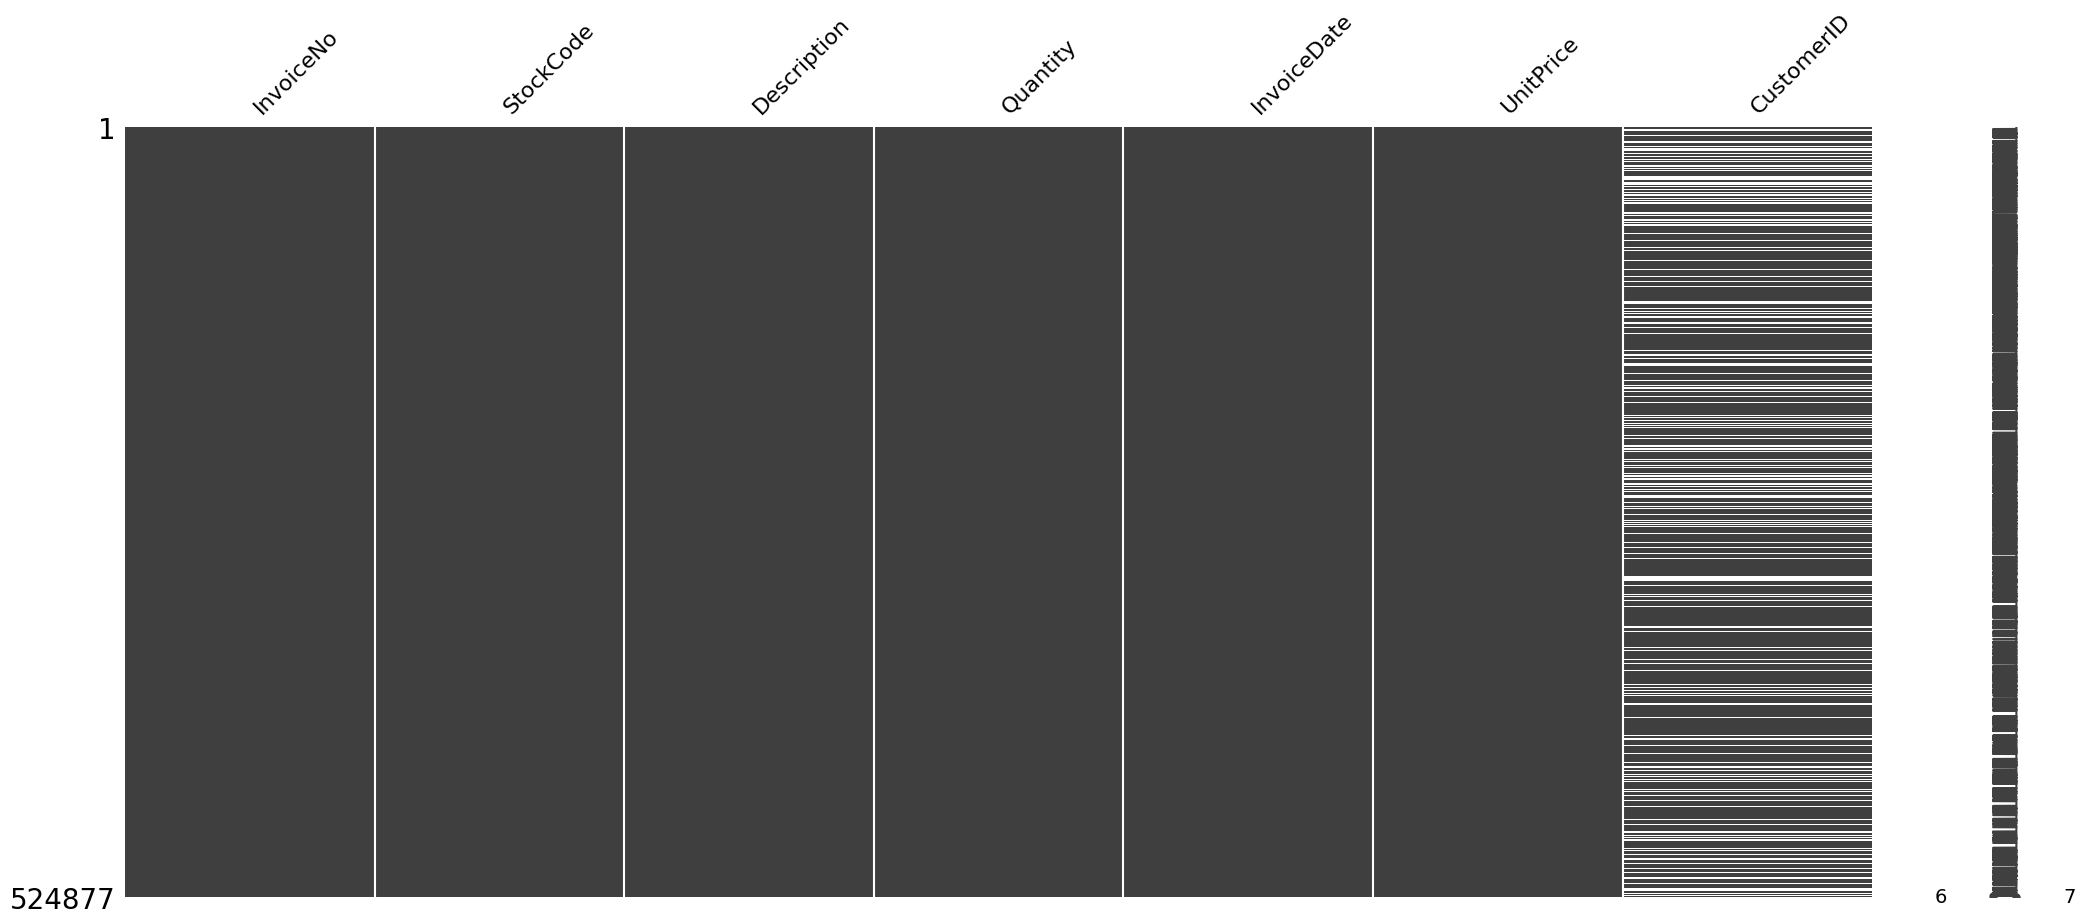

In [19]:
#Visualize missing data
msno.matrix(customer)

dữ liệu gặp lỗi khá nhiều với hơn 100 000 dòng trống chủ yếu ở cột CustomerID, nên sinh viên sẽ gán cột này làm Unknown để xem xét nhóm này, một số giá trị cột số lượng bán ra có giá trị âm -> hợp lí vì đây có thể là sản phẩm bị trả về


In [20]:
customer['CustomerID'] = customer['CustomerID'].fillna('Unknown')

In [21]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524877 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    524877 non-null  object 
 1   StockCode    524877 non-null  object 
 2   Description  524877 non-null  object 
 3   Quantity     524877 non-null  int64  
 4   InvoiceDate  524877 non-null  object 
 5   UnitPrice    524877 non-null  float64
 6   CustomerID   524877 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 32.0+ MB


In [22]:
for col in customer.columns:
    if customer[col].dtype == 'object':
        customer[col] = pd.to_numeric(customer[col], errors='ignore')

In [23]:
customer.describe()

,Quantity,UnitPrice
count,524877.000000,524877.000000
mean,10.616617,3.922576
std,156.280179,36.093062
min,1.000000,0.001000
25%,1.000000,1.250000
50%,4.000000,2.080000
75%,11.000000,4.130000
max,80995.000000,13541.330000


#Data preprocessing

In [24]:
#Tạo cột doanh thu
customer['Revenue'] = customer['Quantity'] *customer['UnitPrice']

In [25]:
#Nhóm các nhóm khách hàng lại
customer_merge = customer.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Revenue': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index().rename(columns={'InvoiceNo': 'Frequency'})
customer_merge.head()

,CustomerID,Quantity,UnitPrice,Revenue,Frequency
0,12346.0,74215,1.040000,77183.60,1
1,12347.0,2458,2.644011,4310.00,7
2,12348.0,2341,5.764839,1797.24,4
3,12349.0,631,8.289041,1757.55,1
4,12350.0,197,3.841176,334.40,1


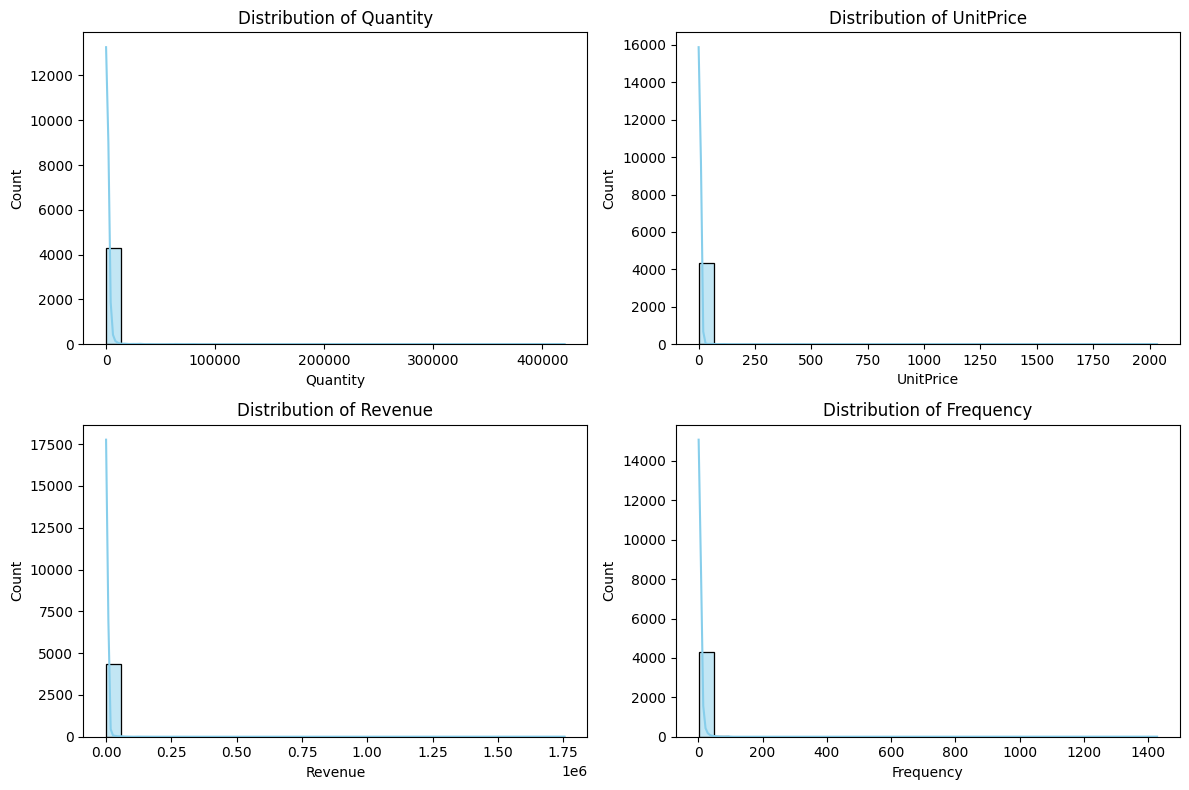

In [26]:
#Phân phối cột số
num_cols = ['Quantity','UnitPrice','Revenue','Frequency']
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(customer_merge[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Dữ liệu bị lệch phải nặng, dùng log transformation để xử lí ddieeuf này

In [27]:
log_cols = ['Quantity', 'UnitPrice', 'Revenue', 'Frequency']
log_cols_transformed = [f'log_{col}' for col in log_cols]
for col in log_cols:
    customer_merge[f'log_{col}'] = np.log(customer_merge[col] + 1)

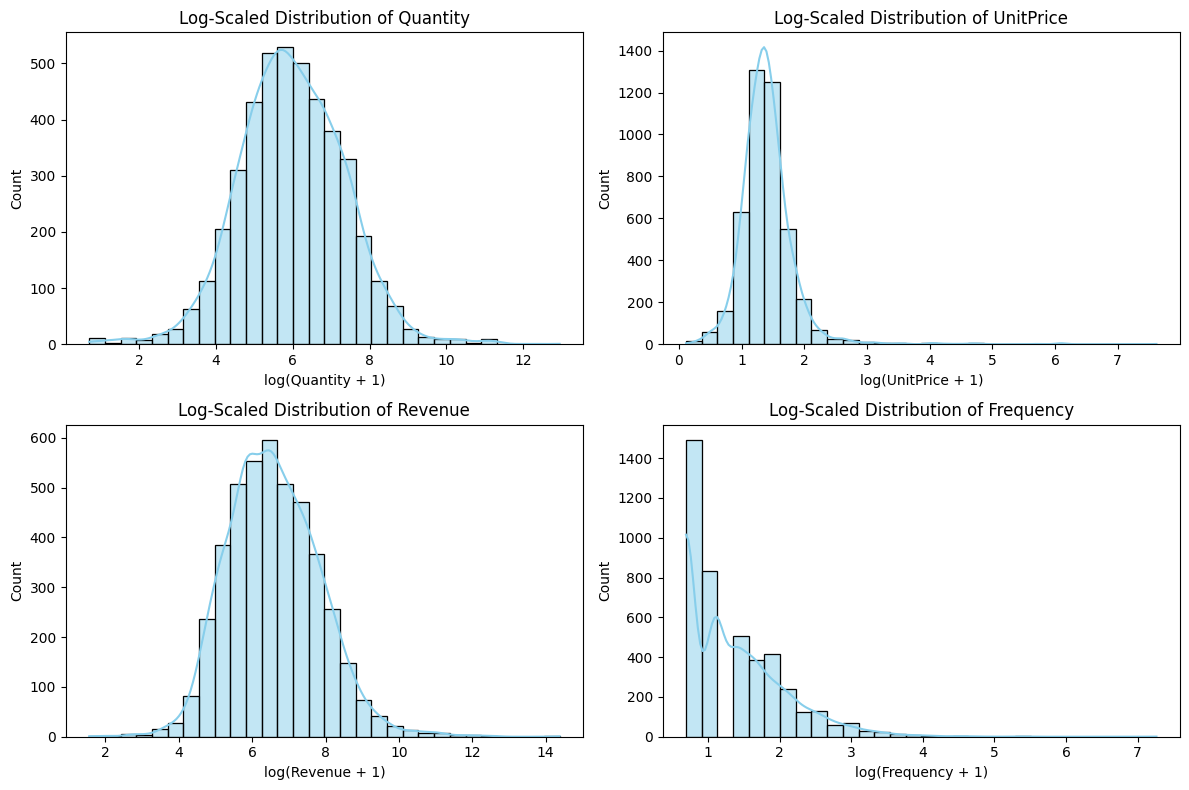

In [28]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(log_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(
        data=customer_merge, x=f'log_{col}',kde=True, bins=30, color='skyblue')
    plt.title(f'Log-Scaled Distribution of {col}', fontsize=12)
    plt.xlabel(f'log({col} + 1)')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

hầu hết các num_cols đều đang ở phân phối gần chuẩn, tuy phân phối của frequency chưa chuẩn lắm, cân nhắc để cột này hỗ trợ cho visualization chứ ko đem vào mô hình

In [29]:
# Chia dữ liệu thành train và test trước
train_data, test_data = train_test_split(customer_merge, test_size=0.2, random_state=42)

In [30]:
#GÁN NHÃN DOANH THU SỬ DỤNG QUANTITLES
quantile_33_train = train_data['Revenue'].quantile(0.33)
quantile_66_train = train_data['Revenue'].quantile(0.66)

print(f"Quantile 33% (thấp) từ train: {quantile_33_train:.2f}")
print(f"Quantile 66% (trung bình) từ train: {quantile_66_train:.2f}")

def assign_label(revenue, q33, q66):
    if revenue <= q33:
        return 'thap'
    elif revenue <= q66:
        return 'trung_binh'
    else:
        return 'cao'

#Gán nhã cho tập train và tập test
train_data['label'] = train_data['Revenue'].apply(assign_label, q33=quantile_33_train, q66=quantile_66_train)
test_data['label'] = test_data['Revenue'].apply(assign_label, q33=quantile_33_train, q66=quantile_66_train)
train_data['label_numeric'] = train_data['label'].map({'thap': 0, 'trung_binh': 1, 'cao': 2})
test_data['label_numeric'] = test_data['label'].map({'thap': 0, 'trung_binh': 1, 'cao': 2})

Quantile 33% (thấp) từ train: 388.46
Quantile 66% (trung bình) từ train: 1149.94


In [31]:
print(train_data['label'].value_counts())
print(test_data['label'].value_counts())

label
cao           1180
thap          1146
trung_binh    1145
Name: count, dtype: int64
label
thap          302
cao           298
trung_binh    268
Name: count, dtype: int64


In [32]:
# Kiểm tra tương quan giữa các đặc trưng và Revenue
print("\nTương quan với Revenue trên train:")
correlation = train_data[log_cols_transformed + ['Revenue']].corr()['Revenue'].drop('Revenue')
print(correlation)



Tương quan với Revenue trên train:
log_Quantity     0.392748
log_UnitPrice    0.033063
log_Revenue      0.437154
log_Frequency    0.391542
Name: Revenue, dtype: float64


In [33]:
features = ['log_Quantity', 'log_UnitPrice', 'log_Frequency']
clean_train_df = train_data[features + ['CustomerID', 'label', 'label_numeric', 'Revenue']].copy()
clean_test_df = test_data[features + ['CustomerID', 'label', 'label_numeric', 'Revenue']].copy()

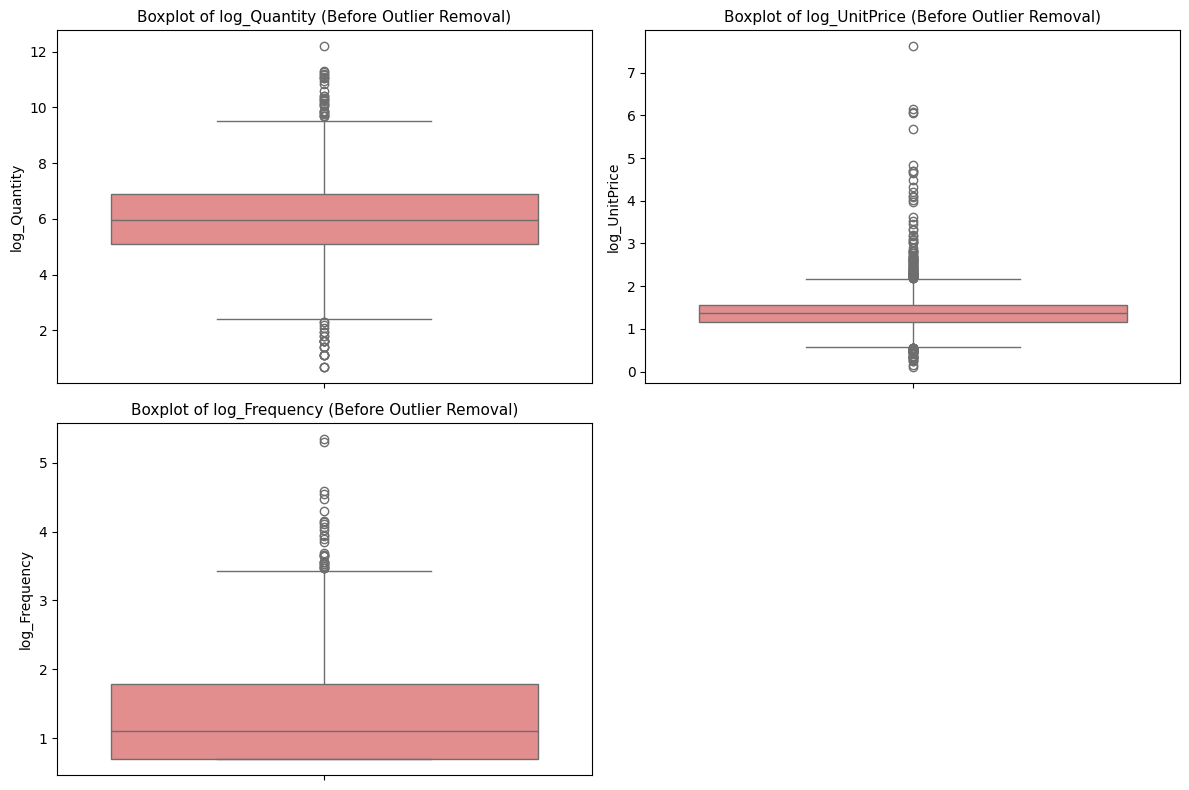

In [34]:
#Xem outlier
plt.figure(figsize=(12, 8))
for i, col in enumerate(['log_Quantity','log_UnitPrice','log_Frequency'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=clean_train_df[f'{col}'], color='lightcoral')
    plt.title(f'Boxplot of {col} (Before Outlier Removal)', fontsize=11)
plt.tight_layout()
plt.show()

In [35]:
def remove_outliers_iqr(df, col, k=2):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

for col in features:
    clean_train_df = remove_outliers_iqr(clean_train_df, col)
    clean_test_df = remove_outliers_iqr(clean_test_df, col)
# Kiểm tra phân bố nhãn sau lọc
print("\nPhân bố nhãn trong clean_train_df:")
print(clean_train_df['label'].value_counts())
print("\nPhân bố nhãn trong clean_test_df:")
print(clean_test_df['label'].value_counts())


Phân bố nhãn trong clean_train_df:
label
cao           1145
trung_binh    1122
thap          1107
Name: count, dtype: int64

Phân bố nhãn trong clean_test_df:
label
thap          298
cao           278
trung_binh    263
Name: count, dtype: int64


In [36]:
#Chuẩn hóa các số
scaler = StandardScaler()
clean_train_df[features] = scaler.fit_transform(clean_train_df[features])
clean_test_df[features] = scaler.transform(clean_test_df[features])

In [37]:
unique_classes = sorted(clean_train_df['label_numeric'].unique())
if len(unique_classes) > 1:
    X_train = clean_train_df[features]
    y_train = clean_train_df['label_numeric']
    X_test = clean_test_df[features]
    y_test = clean_test_df['label_numeric']
    #Huấn luyện model
    model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #Xem kết quả
    target_names = [name for i, name in enumerate(['Thấp', 'Trung bình', 'Cao']) if i in unique_classes]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))



Classification Report:
              precision    recall  f1-score   support

        Thấp       0.93      0.91      0.92       298
  Trung bình       0.82      0.84      0.83       263
         Cao       0.91      0.92      0.92       278

    accuracy                           0.89       839
   macro avg       0.89      0.89      0.89       839
weighted avg       0.89      0.89      0.89       839



In [53]:
y_train_full = clean_train_df[['CustomerID', 'label_numeric']]
y_test_full = clean_test_df[['CustomerID', 'label_numeric']]

y_all = pd.concat([y_train_full, y_test_full], ignore_index=True)
y_all.head()

,CustomerID,label_numeric
0,12625.0,2
1,13645.0,0
2,15136.0,2
3,13731.0,1
4,18158.0,1


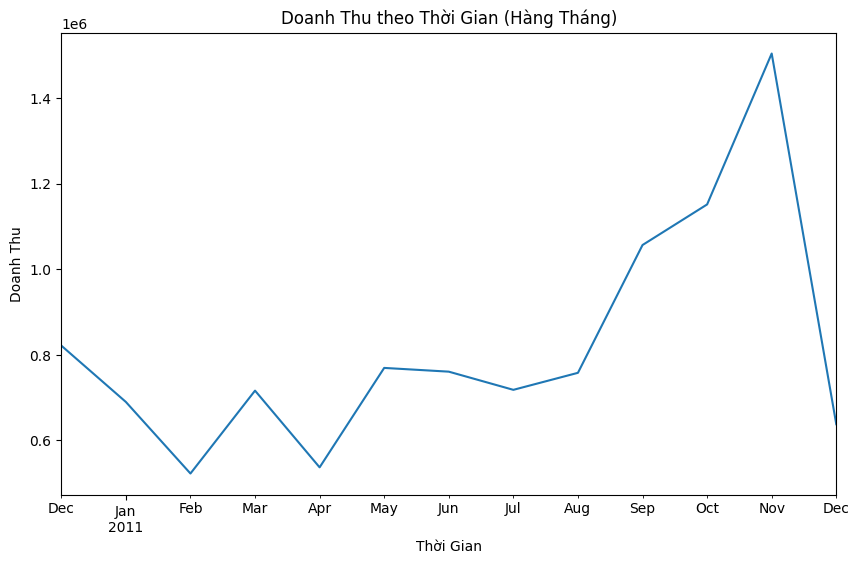

In [39]:
# 1 Line plot doanh thu theo thời gian (hàng tháng)
customer['InvoiceDate'] = pd.to_datetime(customer['InvoiceDate'])
revenue_time = customer.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Revenue'].sum()
plt.figure(figsize=(10, 6))
revenue_time.plot()
plt.title('Doanh Thu theo Thời Gian (Hàng Tháng)')
plt.xlabel('Thời Gian')
plt.ylabel('Doanh Thu')
plt.show()

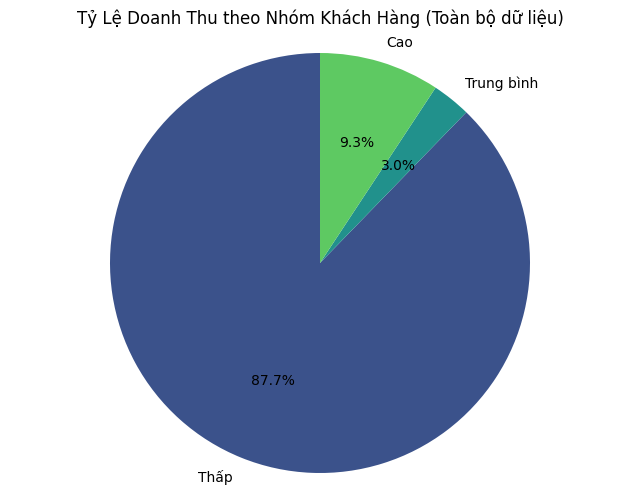

In [55]:
# 2. Pie chart tỷ lệ doanh thu theo nhóm khách hàng
customer_merge['label'] = customer_merge['Revenue'].apply(assign_label, q33=quantile_33_train, q66=quantile_66_train)
customer_merge['label_numeric'] = customer_merge['label'].map({'thap': 0, 'trung_binh': 1, 'cao': 2})

# Tính tổng doanh thu theo nhóm trên toàn bộ customer_merge
revenue_by_group = customer_merge.groupby('label')['Revenue'].sum()

# Vẽ biểu đồ pie
plt.figure(figsize=(8, 6))
plt.pie(revenue_by_group, labels=['Thấp', 'Trung bình', 'Cao'], autopct='%1.1f%%', colors=sns.color_palette('viridis', 3), startangle=90)
plt.title('Tỷ Lệ Doanh Thu theo Nhóm Khách Hàng (Toàn bộ dữ liệu)')
plt.axis('equal')
plt.show()

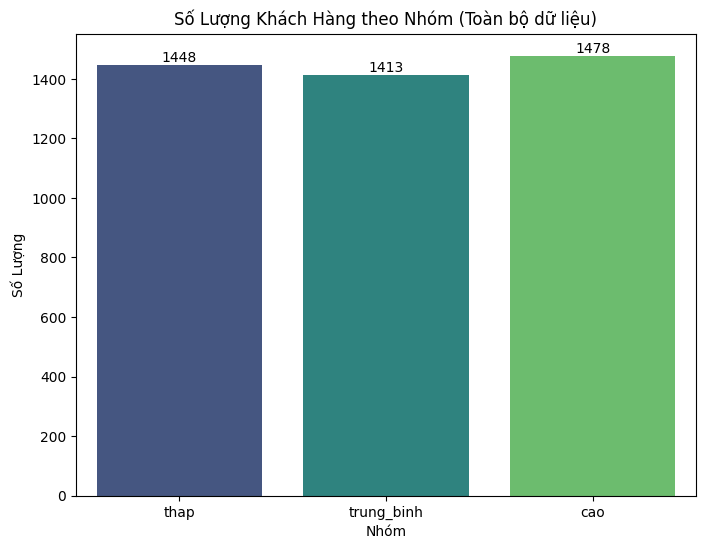

In [56]:
# 1. Bar plot số lượng khách hàng theo nhóm
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=customer_merge, order=['thap', 'trung_binh', 'cao'], palette='viridis')
plt.title('Số Lượng Khách Hàng theo Nhóm (Toàn bộ dữ liệu)', fontsize=12)
plt.xlabel('Nhóm', fontsize=10)
plt.ylabel('Số Lượng', fontsize=10)
for i, v in enumerate(customer_merge['label'].value_counts()[['thap', 'trung_binh', 'cao']].values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

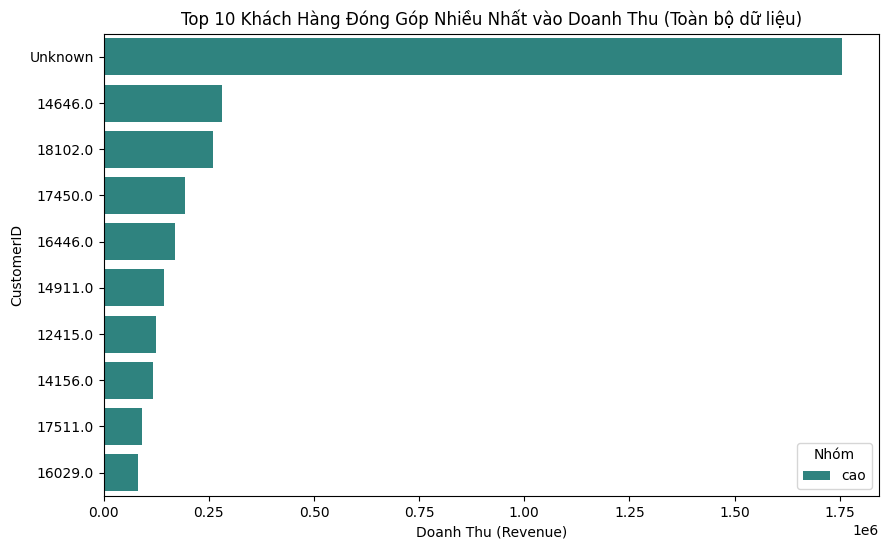

In [57]:

# 4. Bar plot top 10 khách hàng theo doanh thu trong train
top_10_customers = customer_merge[['CustomerID', 'Revenue', 'label']].sort_values(by='Revenue', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Revenue', y='CustomerID', hue='label', data=top_10_customers, palette='viridis')
plt.title('Top 10 Khách Hàng Đóng Góp Nhiều Nhất vào Doanh Thu (Toàn bộ dữ liệu)')
plt.xlabel('Doanh Thu (Revenue)')
plt.ylabel('CustomerID')
plt.legend(title='Nhóm')
plt.show()


In [44]:
# Tính sản phẩm bán chạy (groupby Description)
product_sales = customer.groupby('Description').agg({
    'Quantity': 'sum',
    'Revenue': 'sum'
}).reset_index().sort_values(by='Revenue', ascending=False)


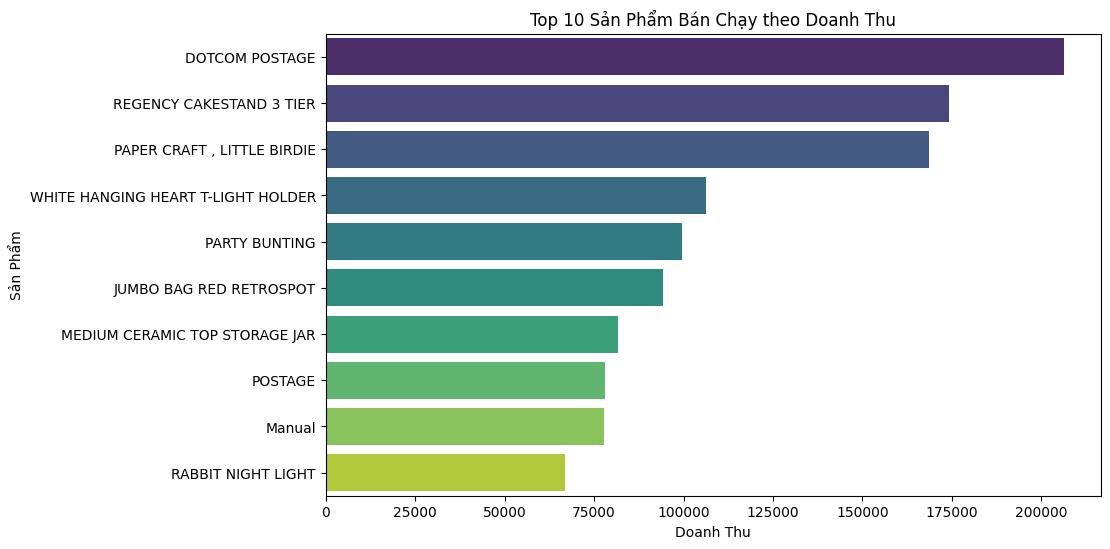

In [45]:
# Bar plot top 10 sản phẩm theo doanh thu
top_10_revenue = product_sales.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Revenue', y='Description', data=top_10_revenue, palette='viridis')
plt.title('Top 10 Sản Phẩm Bán Chạy theo Doanh Thu')
plt.xlabel('Doanh Thu')
plt.ylabel('Sản Phẩm')
plt.show()


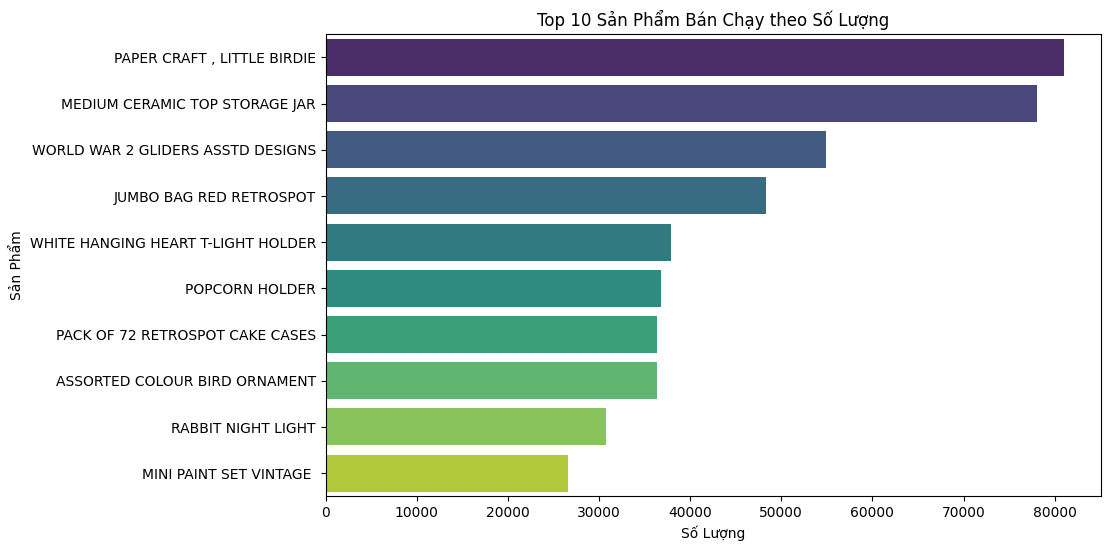

In [46]:
# Bar plot top 10 sản phẩm theo số lượng
top_10_quantity = product_sales.sort_values(by='Quantity', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Quantity', y='Description', data=top_10_quantity, palette='viridis')
plt.title('Top 10 Sản Phẩm Bán Chạy theo Số Lượng')
plt.xlabel('Số Lượng')
plt.ylabel('Sản Phẩm')
plt.show()
